In [127]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [128]:
# data
illum_hyp_unsq = torch.tensor(np.load('../../illum_hyp_unsq.npy'))
illum_img = torch.tensor(np.load('../../illum_img.npy'))
uv1 = torch.tensor(np.load('../../uv1.npy'))

In [129]:
uv1_reshape = uv1.reshape(1, 3, 25, 3, 580, 890)

In [130]:
uv1_integer = uv1_reshape.long()
u_float = (uv1_reshape - uv1_integer)[:,:,:,1]
v_float = (uv1_reshape - uv1_integer)[:,:,:,0]

In [131]:
top_left_weight = (1-u_float) * (1-v_float)
top_right_weight = u_float * (1-v_float)
bott_left_weight = (1-u_float) * v_float
bott_right_weight = u_float * v_float

In [132]:
top_left_weight.shape

torch.Size([1, 3, 25, 580, 890])

In [133]:
# args
proj_H, proj_W = 360, 640
batch_size = 1
wvls_n = 25
m_n= 3
pixel_num = 580*890

In [134]:
def grid_sample(uv1, corner):
        
        if corner == 'A':
                r_proj, c_proj = uv1[:,:,:,1], uv1[:,:,:,0]
                cond = (0<= r_proj)*(r_proj < proj_H)*(0<=c_proj)*(c_proj< proj_W) 
        elif corner == 'B':
                r_proj, c_proj = uv1[:,:,:,1], uv1[:,:,:,0]
                r_proj += 1
                cond = (0<= r_proj)*(r_proj < proj_H)*(0<=c_proj)*(c_proj< proj_W) 
        elif corner == 'C':
                r_proj, c_proj = uv1[:,:,:,1], uv1[:,:,:,0]
                c_proj += 1
                cond = (0<= r_proj)*(r_proj < proj_H)*(0<=c_proj)*(c_proj< proj_W) 
        else:
                r_proj, c_proj = uv1[:,:,:,1], uv1[:,:,:,0]
                r_proj += 1
                c_proj += 1
                cond = (0<= r_proj)*(r_proj < proj_H)*(0<=c_proj)*(c_proj< proj_W) 
        
        r_proj_valid, c_proj_valid = r_proj[cond], c_proj[cond]

        batch_samples = torch.linspace(0, batch_size-1, batch_size)
        wvl_samples = torch.linspace(0, wvls_n-1, wvls_n)
        m_samples = torch.linspace(0, m_n-1, m_n)

        pixel_samples = torch.linspace(0, pixel_num-1, pixel_num)
        grid_b, grid_m, grid_w, grid_pixel = torch.meshgrid(batch_samples,m_samples,wvl_samples,pixel_samples,indexing='ij')

        grid_b_valid = grid_b.reshape(batch_size, m_n, wvls_n, pixel_num)[cond]
        grid_m_valid = grid_m.reshape(batch_size, m_n, wvls_n, pixel_num)[cond]
        grid_w_valid = grid_w.reshape(batch_size, m_n, wvls_n, pixel_num)[cond]
                
        new_idx = m_n * wvls_n * proj_H * proj_W * grid_b_valid \
                + wvls_n * proj_H * proj_W * grid_m_valid \
                + proj_H * proj_W * grid_w_valid \
                + proj_W * r_proj_valid \
                + c_proj_valid

        return new_idx.long(), cond

In [135]:
A, A_cond = grid_sample(uv1.long(), 'A')
B, B_cond = grid_sample(uv1.long(), 'B')
C, C_cond = grid_sample(uv1.long(), 'C')
D, D_cond = grid_sample(uv1.long(), 'D')

In [136]:
hyp_f = illum_hyp_unsq.flatten()

In [137]:
hyp_f = illum_hyp_unsq.flatten()

# 여기서 grid sampling?
valid_pattern_img_A = hyp_f[A]
valid_pattern_img_B = hyp_f[B]
valid_pattern_img_C = hyp_f[C]
valid_pattern_img_D = hyp_f[D]

illum_img[A_cond.flatten()] = valid_pattern_img_A.flatten()
illum_img_A = top_left_weight.flatten() * illum_img

illum_img[B_cond.flatten()] = valid_pattern_img_B.flatten()
illum_img_B = top_right_weight.flatten() * illum_img

illum_img[C_cond.flatten()] = valid_pattern_img_C.flatten()
illum_img_C = bott_left_weight.flatten() * illum_img

illum_img[D_cond.flatten()] = valid_pattern_img_D.flatten()
illum_img_D = bott_right_weight.flatten() * illum_img

In [138]:
illum_img_final = illum_img_A + illum_img_B + illum_img_C + illum_img_D

In [139]:
illum_img_final = illum_img_final.reshape(batch_size, m_n, wvls_n, pixel_num)

In [140]:
illums_m_img = illum_img_final.sum(axis = 1).reshape(batch_size, wvls_n, pixel_num).permute(0,2,1)

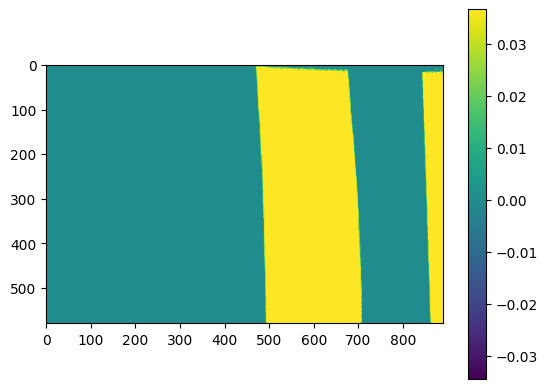

In [141]:
plt.figure()
plt.imshow(illums_m_img.numpy().reshape(580, 890, 25)[:,:,0]), plt.colorbar()
plt.show()